# Circuit analysis: tket example

This notebook will introduce the basic methods of analysis and visualization of circuits available in `pytket`.

It makes use of the modules `pytket_qiskit` and `pytket_cirq` for visualization; these need to be installed (with `pip`) in addition to `pytket`.

We'll start by generating a small circuit to use as an example, and give it a name.

In [1]:
from pytket.circuit import Circuit, OpType

c = Circuit(4, name="example")
c.add_gate(OpType.CU1, 0.5, [0,1])
c.H(0).X(1).Y(2).Z(3)
c.X(0).CX(1,2).Y(1).Z(2).H(3)
c.Y(0).Z(1)
c.add_gate(OpType.CU1, 0.5, [2,3])
c.H(2).X(3)
c.Z(0).H(1).X(2).Y(3).CX(3,0)

[CU1(0.5*PI) q[0], q[1]; Y q[2]; Z q[3]; H q[0]; X q[1]; H q[3]; X q[0]; CX q[1], q[2]; Y q[0]; Y q[1]; Z q[2]; Z q[0]; Z q[1]; CU1(0.5*PI) q[2], q[3]; H q[1]; H q[2]; X q[3]; X q[2]; Y q[3]; CX q[3], q[0]; ]

## Basic statistics

From the circuit we can easily read off the number of qubits ...

In [2]:
c.n_qubits

4

... the name ...

In [3]:
c.name

'example'

... the overall depth of the circuit ...

In [4]:
c.depth()

8

... and the depth by type of gate:

In [5]:
from pytket.circuit import OpType

c.depth_by_type(OpType.CU1), c.depth_by_type(OpType.H)

(2, 2)

This last method counts the number of instances of the specified gate type that cannot be parallelized. Notice that although there are 4 H gates in the circuit, the H-depth is 2 because pairs of them can be parallelized (as will be clear from the visualizations below).

## Visualization

There are several ways to produce useful visualizations of circuits from `pytket`: we can use the built-in `Graph` class to visualize the circuit as a directed acyclic graph (DAG); we can convert the circuit to either Qiskit or Cirq and use the tools provided by those modules; or we can export to Latex.

### Via the `Graph` class

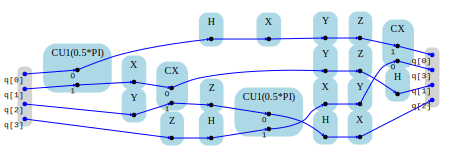

In [6]:
from pytket.utils import Graph

G = Graph(c)
G.get_DAG()

The small numbers (0 and 1) shown at the entry to and exit from the two-qubit gates represent "port numbers" on the gates; these allow us to track individual qubits, which may be placed in a different order on entry and exit in order to simplify the layout.

The `Graph` class also has methods to save this image to a file and to open it in a PDF viewer.

We can also view the qubit connectivity graph of a circuit:

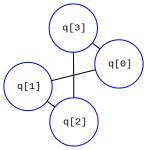

In [7]:
G.get_qubit_graph()

### Via Qiskit

In [8]:
from pytket.extensions.qiskit import tk_to_qiskit

print(tk_to_qiskit(c))

┌───┐┌───┐┌───┐ ┌───┐           ┌───┐
q_0: ─■─────┤ H ├┤ X ├┤ Y ├─┤ Z ├───────────┤ X ├
      │pi/2 ├───┤└───┘├───┤ ├───┤ ┌───┐     └─┬─┘
q_1: ─■─────┤ X ├──■──┤ Y ├─┤ Z ├─┤ H ├───────┼──
      ┌───┐ └───┘┌─┴─┐├───┤ └───┘ ├───┤┌───┐  │  
q_2: ─┤ Y ├──────┤ X ├┤ Z ├─■─────┤ H ├┤ X ├──┼──
      ├───┤ ┌───┐└───┘└───┘ │pi/2 ├───┤├───┤  │  
q_3: ─┤ Z ├─┤ H ├───────────■─────┤ X ├┤ Y ├──■──
      └───┘ └───┘                 └───┘└───┘     


### Via Cirq

In [9]:
from pytket.extensions.cirq import tk_to_cirq

print(tk_to_cirq(c))

0: ───@───────H───X───Y───Z───────────────X───
      │                                   │
1: ───@^0.5───X───@───Y───Z───────H───────┼───
                  │                       │
2: ───Y───────────X───Z───@───────H───X───┼───
                          │               │
3: ───Z───────H───────────@^0.5───X───Y───@───


(Note that Cirq cannot represent all gates diagrammatically.)

### Via Latex

We can create a Latex document containing a diagram of the circuit using the `to_latex_file()` method. This uses the `quantikz` library. The document can be viewed on its own or the Latex can easily be copied and pasted into a larger document.

In [10]:
c.to_latex_file('c.tex')

## Commands

We can retrieve a list of operations comprising a circuit, each represented as a `Command` object:

In [11]:
cmds = c.get_commands()
print(cmds)

[CU1(0.5*PI) q[0], q[1];, Y q[2];, Z q[3];, H q[0];, X q[1];, H q[3];, X q[0];, CX q[1], q[2];, Y q[0];, Y q[1];, Z q[2];, Z q[0];, Z q[1];, CU1(0.5*PI) q[2], q[3];, H q[1];, H q[2];, X q[3];, X q[2];, Y q[3];, CX q[3], q[0];]


Each `Command` is defined by an operation and the qubits it operates on (as well as the classical bits and conditions, if any). For example:

In [12]:
cmd0 = cmds[0]
op0 = cmd0.op
print(op0)
qubits0 = cmd0.args
print(qubits0)

CU1(0.5*PI)
[q[0], q[1]]


From the `Op` we can read off the string representation (in normal or Latex form), the parameters and the type:

In [13]:
op0.get_name() # normal form

'CU1(0.5*PI)'

In [14]:
op0.get_name(latex=True) # Latex form

'\\text{CU1}(0.5\\cdot\\pi)'

In [15]:
op0.type, op0.params

(OpType.CU1, [0.5])

Note that some compilation passes introduce implicit wire swaps at the end of the circuit, which are not represented in the command list. (The internal representation of the circuit as a directed acyclic graph reduces explicit permutations of qubits to implicit features of the graph.) 